In [1]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import openslide
from PIL import Image
import os

# Step 1: Setup S3 client (unsigned for public dataset)
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# Step 2: Choose file
bucket = 'camelyon-dataset'
key = 'CAMELYON16/images/normal_001.tif'
local_file = 'normal_001.tif'

# Step 3: Download once if not already done
if not os.path.exists(local_file):
    print("Downloading slide...")
    s3.download_file(bucket, key, local_file)
else:
    print("Slide already downloaded.")

# Step 4: Open the slide with OpenSlide
slide = openslide.OpenSlide(local_file)

# Step 5: Explore slide metadata
print("Levels:", slide.level_dimensions)
print("Properties:", slide.properties)

# Step 6: Choose a low-res level (e.g. level=2)
level = 2
patch_size = (512, 512)  # in level coordinates
location = (1000, 1000)  # top-left at level 0 (scaled automatically)

# Step 7: Extract patch
region = slide.read_region(location, level, patch_size).convert("RGB")

# Step 8: Save the patch
region.save("patch_level2_1000_1000.png")
print("Patch saved as patch_level2_1000_1000.png")


Levels: ((97792, 221184), (48896, 110592), (24448, 55296), (12224, 27648), (6112, 13824), (3056, 6912), (1528, 3456), (764, 1728), (382, 864), (191, 432))
Properties: <_PropertyMap {'openslide.associated.macro.height': '1577', 'openslide.associated.macro.width': '3629', 'openslide.level-count': '10', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '221184', 'openslide.level[0].tile-height': '512', 'openslide.level[0].tile-width': '512', 'openslide.level[0].width': '97792', 'openslide.level[1].downsample': '2', 'openslide.level[1].height': '110592', 'openslide.level[1].tile-height': '512', 'openslide.level[1].tile-width': '512', 'openslide.level[1].width': '48896', 'openslide.level[2].downsample': '4', 'openslide.level[2].height': '55296', 'openslide.level[2].tile-height': '512', 'openslide.level[2].tile-width': '512', 'openslide.level[2].width': '24448', 'openslide.level[3].downsample': '8', 'openslide.level[3].height': '27648', 'openslide.level[3].tile-height': '512

In [3]:
import os
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from tqdm import tqdm

# Configuration
bucket = 'camelyon-dataset'
prefix = 'CAMELYON16/images/'  # Path in the S3 bucket
download_dir = './camelyon_data'
train_limit_per_class = 11  # ~2GB x 11 = ~22GB
test_limit_per_class = 4    # ~2GB x 4 = ~8GB

# Create download directories
os.makedirs(download_dir, exist_ok=True)
os.makedirs(f'{download_dir}/train/normal', exist_ok=True)
os.makedirs(f'{download_dir}/train/tumor', exist_ok=True)
os.makedirs(f'{download_dir}/test/normal', exist_ok=True)
os.makedirs(f'{download_dir}/test/tumor', exist_ok=True)

# Initialize S3 client
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

# List all keys under the prefix
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket, Prefix=prefix)

normal_files = []
tumor_files = []

print("Listing files...")
for page in pages:
    for obj in page.get('Contents', []):
        key = obj['Key']
        if key.endswith('.tif'):
            if 'tumor' in key.lower():
                tumor_files.append(key)
            elif 'normal' in key.lower():
                normal_files.append(key)

# Sort for reproducibility
normal_files.sort()
tumor_files.sort()

def download_files(file_list, class_type, split, limit):
    print(f"Downloading {limit} {class_type} files for {split} set...")
    for key in tqdm(file_list[:limit]):
        filename = os.path.basename(key)
        dest_path = os.path.join(download_dir, split, class_type, filename)
        if not os.path.exists(dest_path):
            try:
                with open(dest_path, 'wb') as f:
                    s3.download_fileobj(bucket, key, f)
            except Exception as e:
                print(f"Error downloading {key}: {e}")

# Download training files
download_files(normal_files, 'normal', 'train', train_limit_per_class)
download_files(tumor_files, 'tumor', 'train', train_limit_per_class)

# Download testing files
download_files(normal_files[train_limit_per_class:], 'normal', 'test', test_limit_per_class)
download_files(tumor_files[train_limit_per_class:], 'tumor', 'test', test_limit_per_class)

print("Download complete.")


Listing files...


100%|██████████| 11/11 [1:01:52<00:00, 337.50s/it]


100%|██████████| 11/11 [1:41:16<00:00, 552.45s/it]


100%|██████████| 4/4 [35:55<00:00, 538.96s/it]


100%|██████████| 4/4 [1:21:11<00:00, 1217.88s/it]

Download complete.


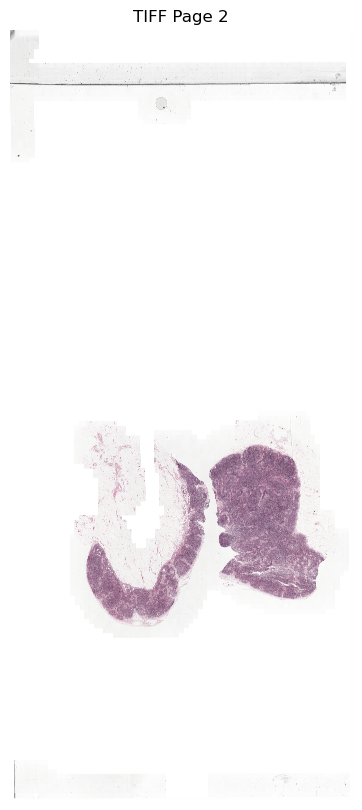

In [25]:
import tifffile
import matplotlib.pyplot as plt

# Path to your TIFF image
tif_path = "camelyon_data/train/normal/normal_009.tif"

# Open the image and read page 10
with tifffile.TiffFile(tif_path) as tif:
    page = tif.pages[2]
    image = page.asarray()

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("TIFF Page 2")
plt.axis("off")
plt.show()


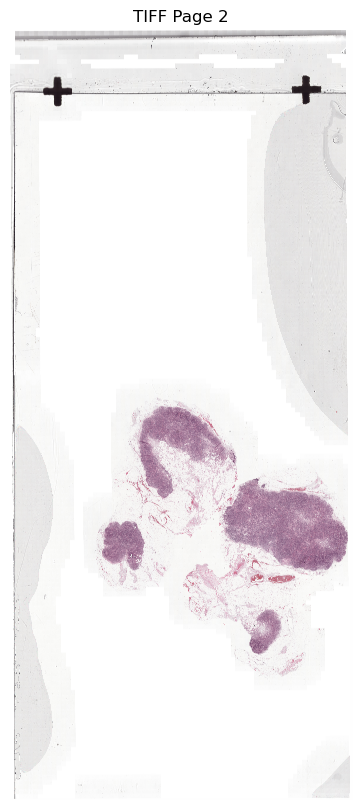

In [1]:
import tifffile
import matplotlib.pyplot as plt

# Path to your TIFF image
tif_path = "camelyon_data/train/tumor/tumor_003.tif"

# Open the image and read page 10
with tifffile.TiffFile(tif_path) as tif:
    page = tif.pages[2]
    image = page.asarray()

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("TIFF Page 2")
plt.axis("off")
plt.show()


Total tissue patches extracted: 28
Displaying first 24 patches


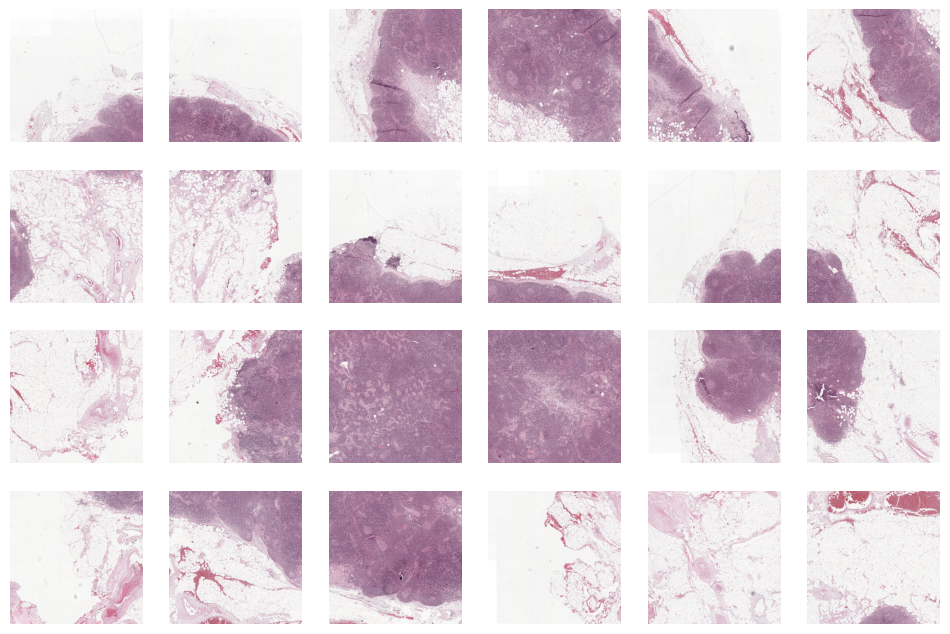

In [19]:
import tifffile
import matplotlib.pyplot as plt

import math


# Path to your TIFF image
# tif_path = "camelyon_data/train/normal/normal_009.tif"
tif_path = "camelyon_data/train/tumor/tumor_003.tif"

# Open the image and read page 2 (index 2)
with tifffile.TiffFile(tif_path) as tif:
    page = tif.pages[4]
    image = page.asarray()

# Patch size
patch_size = 700

# Extract patches
patches = []
for i in range(0, image.shape[0] - patch_size + 1, patch_size):
    for j in range(0, image.shape[1] - patch_size + 1, patch_size):
        patch = image[i:i+patch_size, j:j+patch_size, :]
        if is_tissue(patch) and is_not_blurry(patch):
            patches.append(patch)

# Display only a subset of patches
max_to_display = 24
selected_patches = patches[:max_to_display]

# Grid setup
num_patches = len(selected_patches)
print(f"Total tissue patches extracted: {len(patches)}")
print(f"Displaying first {num_patches} patches")
cols = 6
rows = math.ceil(num_patches / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axs = axs.flatten()

for idx, ax in enumerate(axs):
    if idx < num_patches:
        ax.imshow(selected_patches[idx])
        ax.axis("off")


In [9]:
import numpy as np

def is_tissue(patch):

        r, g, b = patch[..., 0], patch[..., 1], patch[..., 2]

        brightness = (r + g + b) / 3
        if np.mean(brightness) < 40:  # threshold in 0-255 scale
            return False

        max_rgb = np.maximum(np.maximum(r, g), b)
        min_rgb = np.minimum(np.minimum(r, g), b)
        color_variation = max_rgb - min_rgb
        if np.mean(color_variation) < 2:
            return False

        mask = (r > 120) & (b > 80) & (g < 150)
        return np.sum(mask) > 0


In [11]:
import cv2

def is_not_blurry(patch_np, threshold=2000):
    gray = cv2.cvtColor(patch_np, cv2.COLOR_RGB2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance >= threshold
